# State estimation for Comet Atlas/3I
Copyright (c) 2010-2024, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please visit: http://tudat.tudelft.nl/LICENSE.

## Objectives
This example follows a similar process to the [Initial state estimation with Minor Planet Center Observations](estimation_with_mpc.ipynb) example. It is essential to be familiar with the previous example as many concepts will be reused here without explanation.

We will estimate the initial state of **Comet Atlas (3I/2025 N1)**, the third interstellar object ever discovered(!), spotted by the Atlas survey in July 2025. We will showcase how to **read observation data from a local text file** in the MPC 80-column format, with the new Tudat **MPC80ColsParser** functionality, and add these to an already-existing observations table retrieved from the Minor Planet Center. We will also use ephemeris data from JPL Horizons as a method of comparison. This is accomplished using Tudat's HorizonsQuery Interface.

## Import statements

In [1]:
from matplotlib.lines import Line2D
from tudatpy import constants
# Tudat imports for propagation and estimation
from tudatpy.interface import spice
from tudatpy.dynamics import environment_setup, parameters_setup, propagation_setup
from tudatpy import estimation
from tudatpy.estimation import observable_models_setup, estimation_analysis
from tudatpy.astro.frame_conversion import inertial_to_rsw_rotation_matrix
from tudatpy.data.mpc import BatchMPC, MPC80ColsParser
from tudatpy.data.horizons import HorizonsQuery
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tudatpy.astro import time_representation
from tudatpy.astro.time_representation import DateTime
from datetime import datetime
import sys
from astropy.table import Table
import astropy.units as u

## Load Observation Data

**Note:** This example requires a local data file named `additional_observations_3I.txt` in the same directory as this notebook. This file contains [MPC 80-column formatted observations](https://www.minorplanetcenter.net/iau/info/OpticalObs.html) for **Comet Atlas/3I**, as seen from Q54, Harlingten Telescope, Greenhill Observatory, Tasmania. We query `BatchMPC()` twice, one for the standard MPC query, and one to parse the additional observations from our `txt` file. Then we sum the two batches together and convert these into an observation collection. 

In [2]:

batch_mpc= BatchMPC()
MPC_parser = MPC80ColsParser()
time_scale_converter = time_representation.default_time_scale_converter( )
# Define comet name
mpc_codes = ["3I"] #or, alternatively, spkid: 104083, or also spkid: 2025 N1, or simply 3I
batch_mpc.get_observations(mpc_codes, id_types = ['comet_number'])
batch_mpc.summary()

additional_batch = BatchMPC()
# Input file of observations
input_file = './data/additional_observations_3I.txt'
try:
    astropy_table = MPC_parser.parse_80cols_file(input_file)
    if not astropy_table:
        print("No valid observation lines found in the file.")
    else:
        print("Successfully created Astropy Table.")

except FileNotFoundError:
    print(f"Error: File not found at {input_file}")
    print("Please download the observation file and place it in the correct directory.")
    sys.exit(1)
additional_batch.from_astropy(astropy_table, in_degrees = False)

batch = batch_mpc + additional_batch


   Batch Summary:
1. Batch includes 1 minor planets:
   ['3']
2. Batch includes 4249 observations, including 19 observations from space telescopes
3. The observations range from 2025-05-08 12:25:25.737610 to 2025-10-08 23:48:53.769616
   In seconds TDB since J2000: 799979194.922971 to 813239402.951987
   In Julian Days: 2460804.017659 to 2460957.492289
4. The batch contains observations from 228 observatories, including 2 space telescopes

Successfully created Astropy Table.


In [3]:
# LOAD SPICE KERNELS
spice.load_standard_kernels()

In [4]:
# List the bodies for our environment
bodies_to_create = [
    "Sun",
    "Mercury",
    "Venus",
    "Earth",
    "Moon",
    "Mars",
    "Jupiter",
    "Saturn",
    "Uranus",
    "Neptune",
]

# define the frame origin and orientation.
global_frame_origin = "SSB"
global_frame_orientation = "J2000"
# Create system of bodies
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation
)

body_settings.add_empty_settings(mpc_codes[0])
bodies = environment_setup.create_system_of_bodies(body_settings)

In [5]:
# number of iterations for our estimation
number_of_pod_iterations = 6

# 2 month time buffer used to avoid interpolation errors:
time_buffer = 2 * 31 * 86400.0

batch.summary()
print("Summary of space telescopes in batch:")
print(batch.observatories_table(only_space_telescopes=True))
# Retrieve the comet's body name from BatchMPC and set its centre to enable its propagation
bodies_to_propagate = batch.MPC_objects
central_bodies = [global_frame_origin]


   Batch Summary:
1. Batch includes 1 minor planets:
   ['3']
2. Batch includes 4568 observations, including 19 observations from space telescopes
3. The observations range from 2025-05-08 12:25:25.737610 to 2025-10-08 23:48:53.769616
   In seconds TDB since J2000: 799979194.922971 to 813239402.951987
   In Julian Days: 2460804.017659 to 2460957.492289
4. The batch contains observations from 229 observatories, including 2 space telescopes

Summary of space telescopes in batch:
     Code     Name  count
1237  C53  NEOSSat    4.0
1241  C57     TESS   15.0


### Convert the observations to Tudat
Now that our system of bodies is ready, we can retrieve the observation collection from the observations batch using the `to_tudat()` method. By setting the `included_satellites` to `None`, we filter out all space-based observations. From the **observation collection** we can also retrieve **observation links**. As you already know from [Covariance estimation example](covariance_estimated_parameters.ipynb), we use the links to define our **observations settings**. This is also where you would add the **bias settings**. For the purpose of this example, we will use the plain **angular position observation settings**, which can process observations with Right Ascension and Declination. We can also retrieve the times for the first and final observations from the batch object in seconds since J2000 TDB, which is what tudat uses internally. We here add our buffer, set previously, to avoid interpolation errors down the line.

In [6]:
# Transform the MPC observations into a tudat compatible format.
# note that we explicitly exclude all satellite observations in this step by setting included satellites to None.
observation_collection = batch.to_tudat(
    bodies=bodies,
    included_satellites=None,
    apply_star_catalog_debias=True,
    apply_weights_VFCC17=True,
)


# set create angular_position settings for each link in the list.
observation_settings_list = list()
link_list = list(
    observation_collection.get_link_definitions_for_observables(
        observable_type=observable_models_setup.model_settings.angular_position_type
    )
)

for link in link_list:
    # add optional bias settings here
    observation_settings_list.append(
        observable_models_setup.model_settings.angular_position(link, bias_settings=None)
    )

# Retrieve the first and final observation epochs and add the buffer
epoch_start_nobuffer = batch.epoch_start # this is in utc
epoch_end_nobuffer = batch.epoch_end # this is in utc

epoch_start_buffer = epoch_start_nobuffer - time_buffer
epoch_end_buffer = epoch_end_nobuffer + time_buffer

### Creating the acceleration settings
In order to estimate the orbit of the comet, we need to **propagate its initial state**. The propagation can only be performed upon definition of a **dynamical model**. Thus, we need to define the settings of the forces acting on the comet, which will determine its trajectory. We will include:

* **point mass gravity accelerations** for each of the bodies defined before,
* Schwarzschild **relativistic corrections** for the Sun.

With these accelerations we can generate our **acceleration model for the propagation**.

In [7]:
# Define accelerations
accelerations = {
    "Sun": [
        propagation_setup.acceleration.point_mass_gravity(),
        propagation_setup.acceleration.relativistic_correction(use_schwarzschild=True),
    ],
    "Mercury": [propagation_setup.acceleration.point_mass_gravity()],
    "Venus": [propagation_setup.acceleration.point_mass_gravity()],
    "Earth": [propagation_setup.acceleration.point_mass_gravity()],
    "Moon": [propagation_setup.acceleration.point_mass_gravity()],
    "Mars": [propagation_setup.acceleration.point_mass_gravity()],
    "Jupiter": [propagation_setup.acceleration.point_mass_gravity()],
    "Saturn": [propagation_setup.acceleration.point_mass_gravity()],
    "Uranus": [propagation_setup.acceleration.point_mass_gravity()],
    "Neptune": [propagation_setup.acceleration.point_mass_gravity()],
}

# Set up the accelerations settings for each body, in this case only the comet
acceleration_settings = {}
for body in batch.MPC_objects:
    acceleration_settings[str(body)] = accelerations

# create the acceleration models.
acceleration_models = propagation_setup.create_acceleration_models(
    bodies, acceleration_settings, bodies_to_propagate, central_bodies
)

### Retrieving an initial guess for the comet's position
As we mentioned above, we need to propagate an initial state. We use `SPICE` (via a Horizons query) ephemeris to retrieve a 'benchmark' initial state for the comet at the propagation start epoch. We can also use this initial state to set our **initial guess for the estimation**. To define the initial guess, we add a **random uniform offset** of +/- 100,000 kilometers for the position and 1000 m/s for the velocity. Adding this random offset to the `SPICE` initial state should not have a strong influence on the final results, and it is added in order to keep the tutorial representative.

In [8]:
mid_arc_epoch = epoch_start_nobuffer + (epoch_end_nobuffer - epoch_start_nobuffer)/2
print(f'Epoch, Start Arc: {epoch_start_nobuffer}, Mid Arc: {mid_arc_epoch}, End Arc: {epoch_end_nobuffer}')

horizons_query = HorizonsQuery(
    query_id=f"{mpc_codes[0]};",
    location=f"@0", # since our ephemeris origin is the solar system barycenter
    epoch_list=[epoch_start_nobuffer],
    extended_query=True,
)

horizons_ephemeris = horizons_query.cartesian(
    frame_orientation=global_frame_orientation
)

initial_state = horizons_ephemeris[:,1:][0]
print(f'JPL Horizons Initial State: {initial_state}')

# Add random offset for initial guess
rng = np.random.default_rng(seed=1)

initial_position_offset = 1e5 * 1000
initial_velocity_offset =  1000

initial_guess = initial_state.copy()

initial_guess[0:3] += (2 * rng.random(3) - 1) * initial_position_offset
initial_guess[3:6] += (2 * rng.random(3) - 1) * initial_velocity_offset

print("Error between the real initial state and our initial guess:")
print(initial_guess - initial_state)

Epoch, Start Arc: 799979194.922971, Mid Arc: 806609298.937479, End Arc: 813239402.951987
JPL Horizons Initial State: [ 1.50958150e+11 -8.76180447e+11 -3.20048883e+11 -2.38590075e+04
  5.17874303e+04  1.97426436e+04]
Error between the real initial state and our initial guess:
[ 2.36432494e+06  9.00927393e+07 -7.11680775e+07  8.97298894e+02
 -3.76337096e+02 -1.53347102e+02]


### Finalising the propagation setup
For the integrator we use a variable timestep RKF-7(8) integrator. We set our initial time to the time of the batch's first observation (without buffer). We then set the termination to stop at the time of the batch's final observation plus buffer. These two settings are then the final pieces to create our propagation settings.

In [9]:
# Create numerical integrator settings with the correct arguments
integrator_settings = propagation_setup.integrator.runge_kutta_variable_step_size(
    initial_time_step=3600.0,  # Start with a 1-hour time step
    coefficient_set=propagation_setup.integrator.CoefficientSets.rkf_78,
    minimum_step_size=10.0,      # Allow steps as small as 10 seconds
    maximum_step_size=3 * 86400.0, # Allow steps as large as 3 days
    relative_error_tolerance=1.0e-12,
    absolute_error_tolerance=1.0e-12
)

# Terminate at the time of oldest observation (this was already correct)
termination_condition = propagation_setup.propagator.time_termination(epoch_end_buffer)

# Create propagation settings (this part was also correct)
propagator_settings = propagation_setup.propagator.translational(
    central_bodies=central_bodies,
    acceleration_models=acceleration_models,
    bodies_to_integrate=bodies_to_propagate,
    initial_states=initial_guess,
    initial_time=time_representation.Time(epoch_start_nobuffer), # This is the correct place for the start time
    integrator_settings=integrator_settings,
    termination_settings=termination_condition,
)

## Setting Up the estimation
With the observation collection, the environment and propagations settings ready we can now begin setting up our estimation.
In this example **we will simply estimate the position of Comet Atlas** and as such only include an **initial states parameter**.

In [10]:
# Setup parameters settings to propagate the state transition matrix
parameter_settings = parameters_setup.initial_states(
    propagator_settings, bodies
)

# Create the parameters that will be estimated
parameters_to_estimate = parameters_setup.create_parameter_set(
    parameter_settings, bodies, propagator_settings
)

The `Estimator` object collects the environment, observation settings and propagation settings. We also create an `EstimationInput` object and provide it our observation collection retrieved from `.to_tudat()`. Our maximum iterations steps was set to 6.

In [11]:
# Set up the estimator
estimator = estimation_analysis.Estimator(
    bodies=bodies,
    estimated_parameters=parameters_to_estimate,
    observation_settings=observation_settings_list,
    propagator_settings=propagator_settings,
    integrate_on_creation=True,
)

# provide the observation collection as input, and limit number of iterations for estimation.
pod_input = estimation_analysis.EstimationInput(
    observations_and_times=observation_collection,
    convergence_checker=estimation.estimation_analysis.estimation_convergence_checker(
        maximum_iterations=number_of_pod_iterations,
    ),
)

pod_input.define_estimation_settings(
    reintegrate_equations_on_first_iteration=False,
    reintegrate_variational_equations=False,
    print_output_to_terminal=True,
    save_state_history_per_iteration=True,
)

observation_collection.set_tabulated_weights(observation_collection.concatenated_weights)

## Performing the estimation

With everything set up, we can now perform the estimation.

In [12]:
# Perform the estimation
pod_output = estimator.perform_estimation(pod_input)

Calculating residuals and partials 9098
Current residual: 0.0123685
Parameter update-3.75026e+08  1.00338e+09  4.33311e+08     -826.478       299.26      130.496
Calculating residuals and partials 9098
Current residual: 7.67499e-05
Parameter update 3.84218e+08 -1.11411e+09  -3.6901e+08     -73.2357      77.6152      23.0475
Calculating residuals and partials 9098
Current residual: 2.83901e-06
Parameter update 1.19181e+06 -3.29794e+06 -1.09784e+06      -0.2316     0.204403    0.0642695
Calculating residuals and partials 9098
Current residual: 2.84148e-06
Parameter update     3286.2    -7564.98    -2552.45  -0.0006538 0.000333077 0.000115743
Calculating residuals and partials 9098
Current residual: 2.84148e-06
Parameter update     12.2482     -26.3684     -8.94574 -2.44202e-06  1.05961e-06  3.78243e-07
Calculating residuals and partials 9098
Current residual: 2.84148e-06
Maximum number of iterations reached
Parameter update   0.0460373   -0.0986015   -0.0335655 -9.16277e-09  3.97072e-09 

Looking at the **residual values** after each iteration, the estimator appears to converge within ~4 steps. Lets check how close our **initial state guess** and the **final estimate for the initial state** are, compared to the benchmark initial state.

In [13]:
# retrieve the estimated initial state.
parameter_history = pod_output.parameter_history
tudat_initial_state = parameter_history[:,-1]
vector_error_initial = (np.array(initial_guess) - initial_state)[0:3]
error_magnitude_initial = np.sqrt(np.square(vector_error_initial).sum()) / 1000

vector_error_final = (np.array(tudat_initial_state) - initial_state)[0:3]
error_magnitude_final = np.sqrt(np.square(vector_error_final).sum()) / 1000

print(
    f"{mpc_codes} initial guess radial error to Horizons: {round(error_magnitude_initial, 2)} km"
)
print(
    f"{mpc_codes} final radial error to Horizons: {round(error_magnitude_final, 2)} km"
)

['3I'] initial guess radial error to Horizons: 114835.48 km
['3I'] final radial error to Horizons: 28275.02 km


## Visualising the results

### Change in residuals per iteration
We want to visualise the residuals, splitting them between Right Ascension and Declination. Internally, `concatenated_observations` orders the observations alternating RA, DEC, RA, DEC,... This allows us to map the colors accordingly by taking every other item in the `residual_history`/`concatenated_observations`, i.e. by slicing [::2].

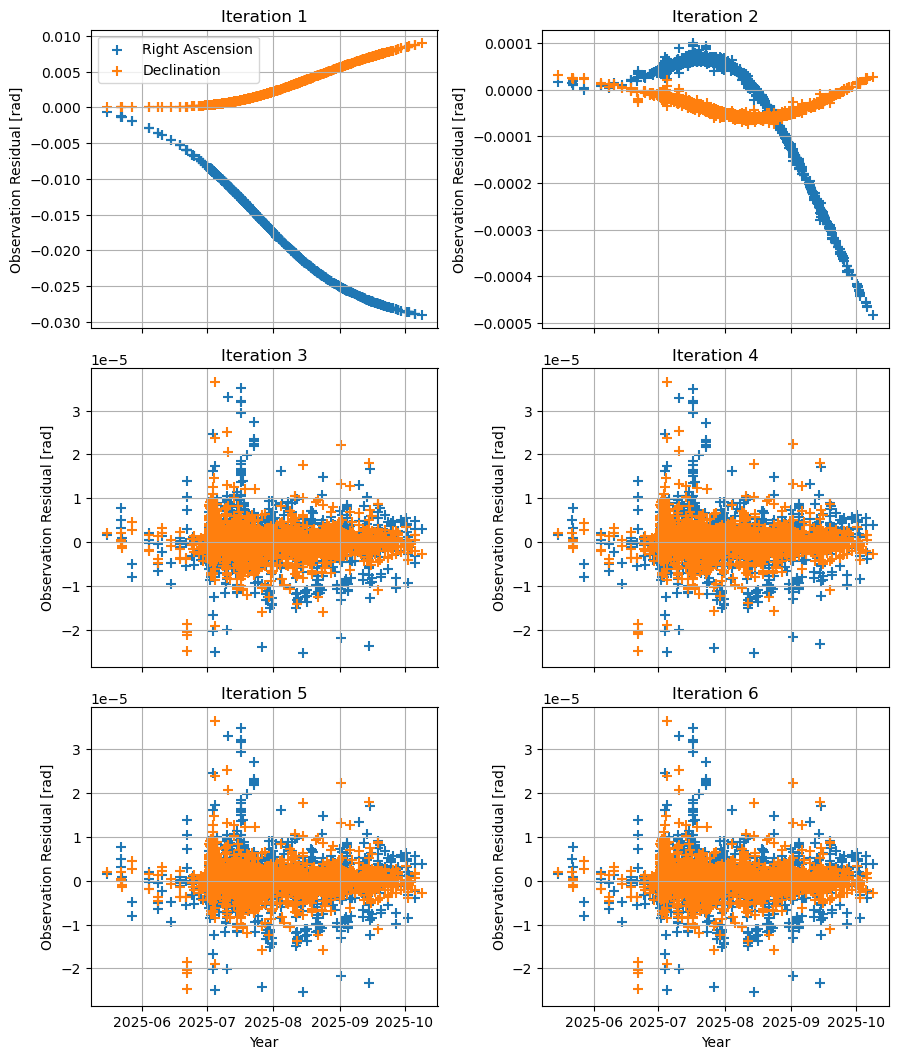

In [14]:
residual_history = pod_output.residual_history

# Number of columns and rows for our plot
number_of_columns = 2

number_of_rows = (
    int(number_of_pod_iterations / number_of_columns)
    if number_of_pod_iterations % number_of_columns == 0
    else int((number_of_pod_iterations + 1) / number_of_columns)
)

fig, axs = plt.subplots(
    number_of_rows,
    number_of_columns,
    figsize=(9, 3.5 * number_of_rows),
    sharex=True,
    sharey=False,
)

residual_times = np.array([DateTime.from_epoch(concatenated_time).to_python_datetime() for concatenated_time in observation_collection.concatenated_times])


# plot the residuals, split between RA and DEC types
for idx, ax in enumerate(fig.get_axes()):
    ax.grid()
    # we take every second
    ax.scatter(
        residual_times[::2],
        residual_history[
        ::2,
        idx,
        ],
        marker="+",
        s=60,
        label="Right Ascension",
    )
    ax.scatter(
        residual_times[1::2],
        residual_history[
        1::2,
        idx,
        ],
        marker="+",
        s=60,
        label="Declination",
    )
    ax.set_ylabel("Observation Residual [rad]")
    ax.set_title("Iteration " + str(idx + 1))

plt.tight_layout()

# add the year label for the x-axis
for col in range(number_of_columns):
    axs[int(number_of_rows - 1), col].set_xlabel("Year")

axs[0, 0].legend()

plt.show()

### Residuals Correlations Matrix
Lets check out the correlation of the estimated parameters.

Calculating residuals and partials 9098


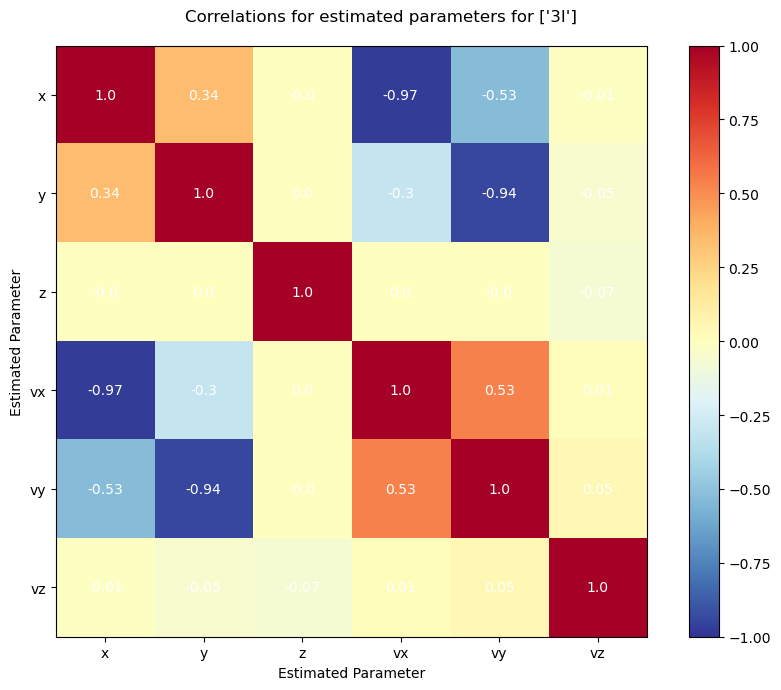

In [15]:
# Correlation can be retrieved using the CovarianceAnalysisInput class:
covariance_input = estimation_analysis.CovarianceAnalysisInput(observation_collection)
covariance_output = estimator.compute_covariance(covariance_input)

correlations = covariance_output.correlations
estimated_param_names = ["x", "y", "z", "vx", "vy", "vz"]

fig, ax = plt.subplots(1, 1, figsize=(9, 7))

im = ax.imshow(correlations, cmap=cm.RdYlBu_r, vmin=-1, vmax=1)

ax.set_xticks(np.arange(len(estimated_param_names)), labels=estimated_param_names)
ax.set_yticks(np.arange(len(estimated_param_names)), labels=estimated_param_names)

# add numbers to each of the boxes
for i in range(len(estimated_param_names)):
    for j in range(len(estimated_param_names)):
        text = ax.text(
            j, i, round(correlations[i, j], 2), ha="center", va="center", color="w"
        )

cb = plt.colorbar(im)

ax.set_xlabel("Estimated Parameter")
ax.set_ylabel("Estimated Parameter")

fig.suptitle(f"Correlations for estimated parameters for {mpc_codes}")

fig.set_tight_layout(True)
plt.show()

### Final residuals highlighted per observatory
This plot shows the final iteration of the residuals, highlighting the 10 observatories with the most observations.

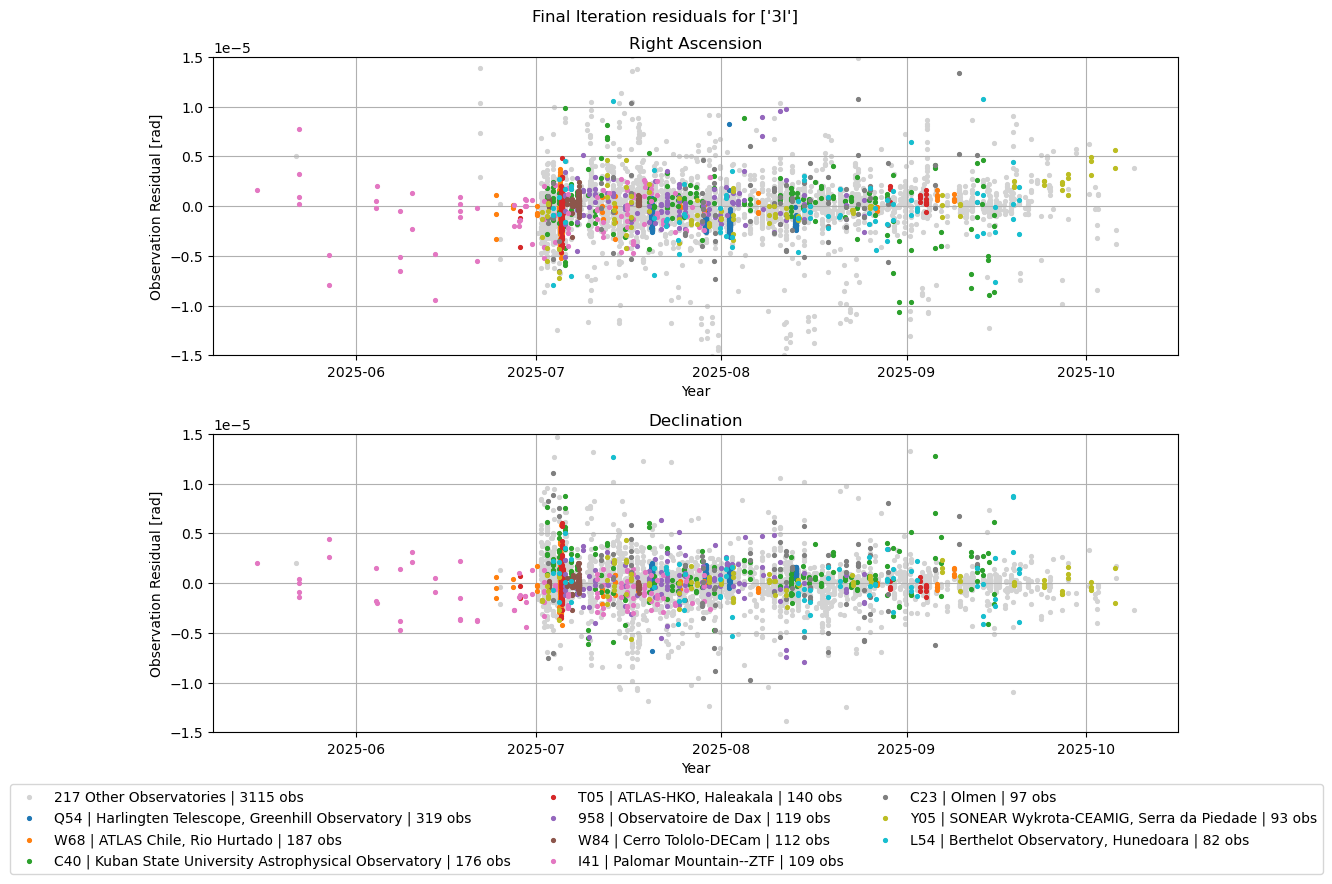

In [16]:
# 10 observatories with most observations
num_observatories = 10

final_residuals = np.array(residual_history[:, -1])
# if you would like to check the iteration 1 residuals, use:
# final_residuals = np.array(residual_history[:, 0])

# This piece of code collects the 10 largest observatories
observatory_names = (
    batch.observatories_table(exclude_space_telescopes=True)
    .sort_values("count", ascending=False)
    .iloc[0:num_observatories]
    .set_index("Code")
)
top_observatories = observatory_names.index.tolist()

# This piece of code creates a `concatenated_receiving_observatories` map
# to identify the observatories by their MPC code instead of an internally used id
residuals_observatories = observation_collection.concatenated_link_definition_ids
unique_observatories = set(residuals_observatories)

observatory_link_to_mpccode = {
    idx: observation_collection.link_definition_ids[idx][
        observable_models_setup.links.receiver
    ].reference_point
    for idx in unique_observatories
}

# the resulting map (MPC code for each item in the residuals_history):
concatenated_receiving_observatories = np.array(
    [observatory_link_to_mpccode[idx] for idx in residuals_observatories]
)

# mask for the observatories not in top 10:
mask_not_top = [
    (False if observatory in top_observatories else True)
    for observatory in concatenated_receiving_observatories
]

# get the number of observations by the other observatories
# (divide by two because the observations are concatenated RA,DEC in this list)
n_obs_not_top = int(sum(mask_not_top) / 2)

fig, axs = plt.subplots(2, 1, figsize=(13, 9))

# Plot remaining observatories first
# RA
axs[0].scatter(
    residual_times[mask_not_top][::2],
    final_residuals[mask_not_top][::2],
    marker=".",
    s=30,
    label=f"{len(unique_observatories) - num_observatories} Other Observatories | {n_obs_not_top} obs",
    color="lightgrey",
)
# DEC
axs[1].scatter(
    residual_times[mask_not_top][1::2],
    final_residuals[mask_not_top][1::2],
    marker=".",
    s=30,
    label=f"{len(unique_observatories) - num_observatories} Other Observatories | {n_obs_not_top} obs",
    color="lightgrey",
)

# plots the highlighted top 10 observatories
for observatory in top_observatories:
    name = f"{observatory} | {observatory_names.loc[observatory].Name} | {int(observatory_names.loc[observatory]['count'])} obs"
    axs[0].scatter(
        residual_times[concatenated_receiving_observatories == observatory][::2],
        final_residuals[concatenated_receiving_observatories == observatory][::2],
        marker=".",
        s=30,
        label=name,
        zorder=100,
    )
    axs[1].scatter(
        residual_times[concatenated_receiving_observatories == observatory][1::2],
        final_residuals[concatenated_receiving_observatories == observatory][1::2],
        marker=".",
        s=30,
        label=name,
        zorder=100,
    )


axs[1].legend(ncols=3, loc="upper center", bbox_to_anchor=(0.47, -0.15))

for ax in fig.get_axes():
    ax.grid()
    ax.set_ylabel("Observation Residual [rad]")
    ax.set_xlabel("Year")
    # this step hides a few outliers (~3 observations)
    ax.set_ylim(-1.5e-5, 1.5e-5)

axs[0].set_title("Right Ascension")
axs[1].set_title("Declination")

fig.suptitle(f"Final Iteration residuals for {mpc_codes}")
fig.set_tight_layout(True)

plt.show()

### Residual Boxplots per observatory
Let's visualise these residuals as boxplots as well, again splitting for right ascension and declination. Note that some low level Matplotlib is used for this plot. Consider using the simplified [seaborn boxplot](https://seaborn.pydata.org/generated/seaborn.boxplot.html) implementation if this format is relevant to your use case.

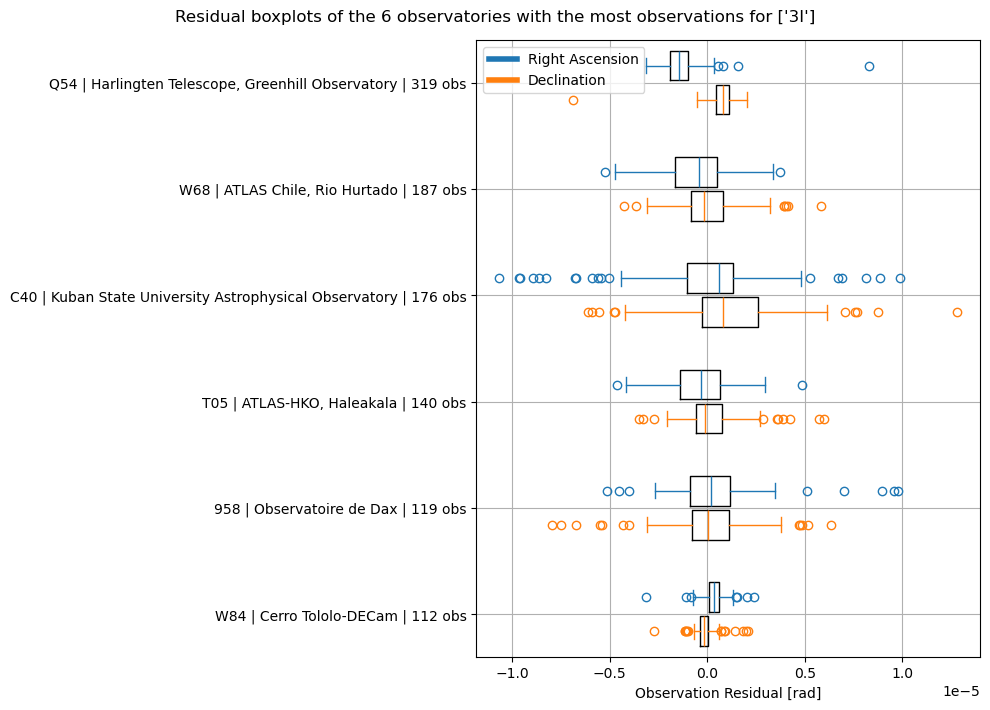

In [17]:
num_observatories = 6

data_per_observatory_list_RA = []
data_per_observatory_list_DEC = []
names = []

fig, ax = plt.subplots(1, 1, figsize=(10, 1.2 * num_observatories))

# we retrieve the observatory names again
observatory_names_box = (
    batch.observatories_table(exclude_space_telescopes=True)
    .set_index("Code")
    .sort_values("count", ascending=False)
    .iloc[0:num_observatories]
)

top_observatories_box = observatory_names_box.index.tolist()

# retrieve the data for RA and DEC separately
for observatory in top_observatories_box[::-1]:
    name = f"{observatory} | {observatory_names_box.loc[observatory].Name} | {int(observatory_names_box.loc[observatory]['count'])} obs"
    names.append(name)
    data_per_observatory_list_RA.append(
        final_residuals[concatenated_receiving_observatories == observatory][::2]
    )

    data_per_observatory_list_DEC.append(
        final_residuals[concatenated_receiving_observatories == observatory][1::2]
    )

# positioning the boxes
pos = (np.arange(0, len(top_observatories_box)) + 1) * 10
widths = 2.8
offset = 1.6

# box colors
RA_color = "tab:blue"
DEC_color = "tab:orange"

# boxes for RA and DEC
RAplots = ax.boxplot(
    x=data_per_observatory_list_RA,
    vert=False,
    positions=pos + offset,
    widths=widths,
    patch_artist=False,
    capprops=dict(color=RA_color),
    whiskerprops=dict(color=RA_color),
    flierprops=dict(color=RA_color, markeredgecolor=RA_color),
    medianprops=dict(color=RA_color),
)
DECplots = ax.boxplot(
    x=data_per_observatory_list_DEC,
    vert=False,
    positions=pos - offset,
    widths=widths,
    patch_artist=False,
    capprops=dict(color=DEC_color),
    whiskerprops=dict(color=DEC_color),
    flierprops=dict(color=DEC_color, markeredgecolor=DEC_color),
    medianprops=dict(color=DEC_color),
)
# custom ticks
ax.set_yticks(ticks=pos, labels=names)

# custom legend
place_holder_lines = [
    Line2D([0], [0], color=RA_color, lw=4),
    Line2D([0], [0], color=DEC_color, lw=4),
]
ax.legend(place_holder_lines, ["Right Ascension", "Declination"])

ax.grid()
ax.set_xlabel("Observation Residual [rad]")

fig.suptitle(
    f"Residual boxplots of the {num_observatories} observatories with the most observations for {mpc_codes}"
)

# reducing whitespace
ax.set_ylim(10 - 4, int(len(top_observatories_box) * 10) + 4)

fig.set_tight_layout(True)
plt.show()

### Histograms per observatory
Finally, lets get the residual histogram for the top 6 observatories, splitting again for right ascension and declination.

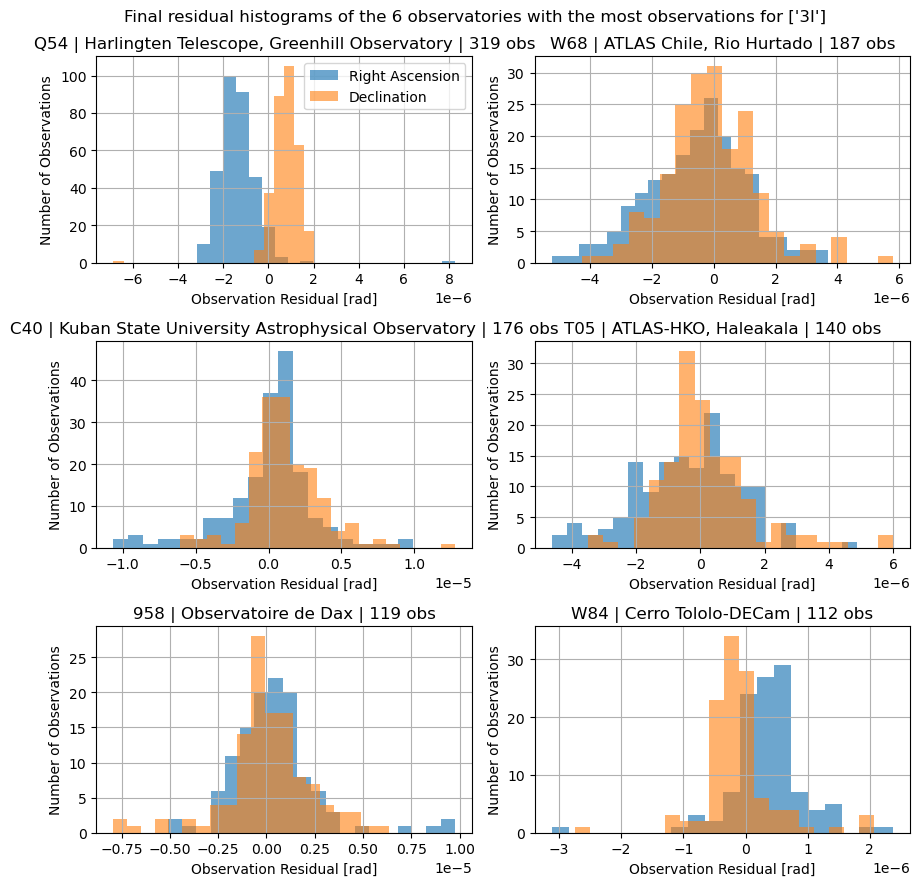

In [18]:
num_observatories = 6
nbins = 20
number_of_columns = 2
transparency = 0.6



number_of_rows = (
    int(num_observatories / number_of_columns)
    if num_observatories % number_of_columns == 0
    else int((num_observatories + 1) / number_of_columns)
)

# we retrieve the observatory names again
observatory_names_hist = (
    batch.observatories_table(exclude_space_telescopes=True)
    .set_index("Code")
    .sort_values("count", ascending=False)
    .iloc[0:num_observatories]
)

top_observatories_hist = observatory_names_hist.index.tolist()


fig, axs = plt.subplots(
    number_of_rows,
    number_of_columns,
    figsize=(4.5 * number_of_columns, 3 * number_of_rows),
)

axs = axs.flatten()

for idx, observatory in enumerate(top_observatories_hist):
    name = f"{observatory} | {observatory_names_hist.loc[observatory].Name} | {int(observatory_names_hist.loc[observatory]['count'])} obs"

    axs[idx].hist(
        final_residuals[concatenated_receiving_observatories == observatory][0::2],
        bins=nbins,
        alpha=transparency + 0.05,
        label="Right Ascension",
    )
    axs[idx].hist(
        final_residuals[concatenated_receiving_observatories == observatory][1::2],
        bins=nbins,
        alpha=transparency,
        label="Declination",
    )

    axs[idx].grid()
    axs[idx].set_title(name)
    axs[idx].set_ylabel("Number of Observations")
    axs[idx].set_xlabel("Observation Residual [rad]")

axs[0].legend()

fig.suptitle(
    f"Final residual histograms of the {num_observatories} observatories with the most observations for {mpc_codes}"
)
fig.set_tight_layout(True)
plt.show()

## Additional Analysis

The following cells perform some extra analysis on the results, comparing the input observations to Horizons data and plotting the final trajectory and its uncertainty.

### Observation Comparison (MPC vs. Horizons)

Here, we compare the observations from our input file against the ephemeris from JPL Horizons.

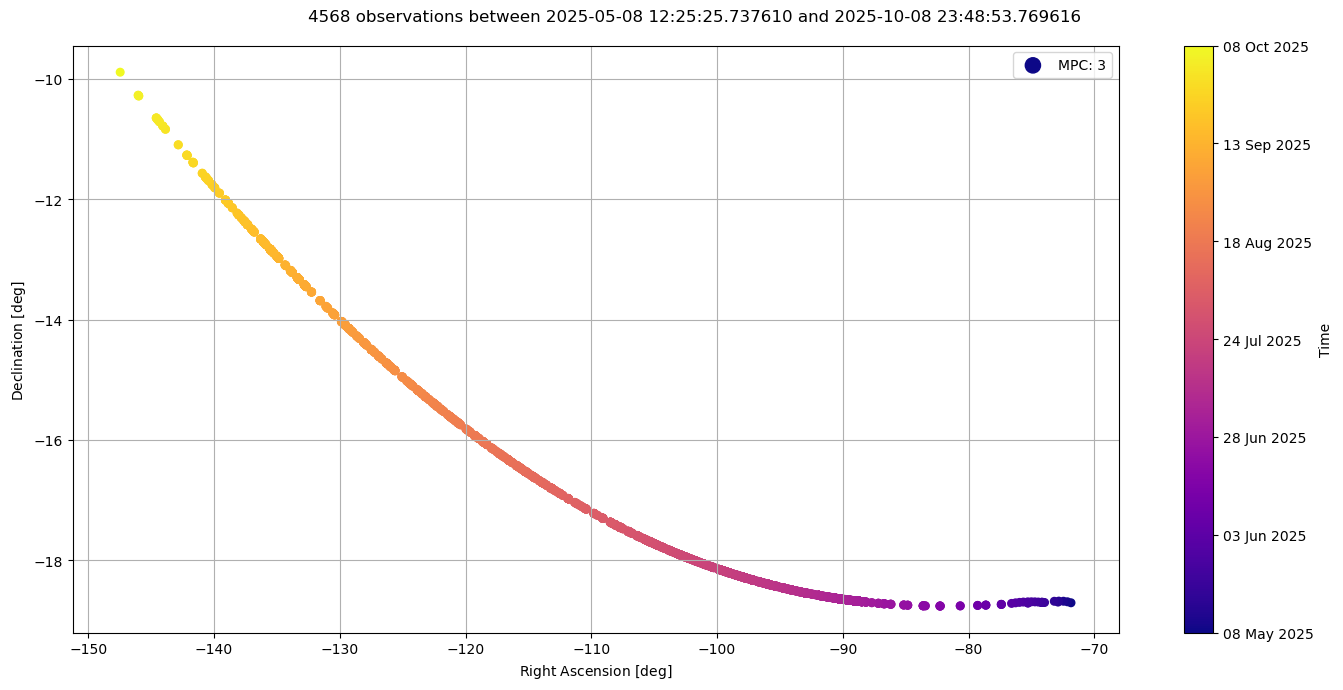

Maximum difference between Interpolated Horizons data and MPC observations...
...in Right Ascension: 0.0003167946 rad
...in Declination: 0.0003323638 rad
Minimum difference between Interpolated Horizons data and MPC observations...
...in Right Ascension: 6e-10 rad
...in Declination: 7e-10 rad


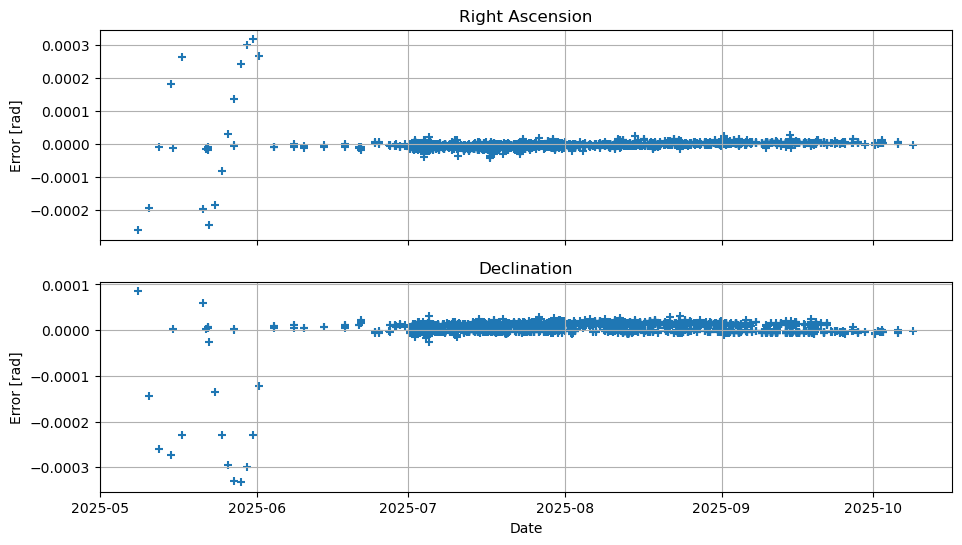

In [19]:
# Retrieve MPC observation times, RA and DEC from batch object
batch_times_tdb = batch.table.epochJ2000secondsTDB.to_list() # in tdb

batch_times_utc = [time_scale_converter.convert_time(
    input_scale = time_representation.tdb_scale,
    output_scale = time_representation.utc_scale,
    input_value = utc_second) for utc_second in batch_times_tdb
]

batch_times_utc_date = batch.table.epochUTC.to_list()
batch_RA = batch.table.RA #in radians
batch_DEC = batch.table.DEC #in radians

# Try some of the other projections: 'hammer', 'mollweide' and 'lambert'
fig = batch.plot_observations_sky()
plt.show()

# Create Horizons query, see Horizons Documentation for more info.
atlas_horizons_query = HorizonsQuery(
    query_id=mpc_codes[0],
    location="@399", # since our observers are located on earth
    epoch_list=batch_times_tdb,
    extended_query=True,
)

# retrieve JPL observations
jpl_observations = atlas_horizons_query.interpolated_observations()
jpl_RA = jpl_observations[:, 1] % np.pi - np.pi #normalize RA to the interval [-pi,pi]
jpl_DEC = jpl_observations[:,2]


#take the difference
max_diff_RA = np.abs(jpl_RA - batch_RA).max()
max_diff_DEC = np.abs(jpl_DEC - batch_DEC).max()
min_diff_RA = np.abs(jpl_RA - batch_RA).min()
min_diff_DEC = np.abs(jpl_DEC - batch_DEC).min()

print("Maximum difference between Interpolated Horizons data and MPC observations...")
print(f"...in Right Ascension: {np.round(max_diff_RA, 10)} rad")
print(f"...in Declination: {np.round(max_diff_DEC, 10)} rad")

print("Minimum difference between Interpolated Horizons data and MPC observations...")
print(f"...in Right Ascension: {np.round(min_diff_RA, 10)} rad")
print(f"...in Declination: {np.round(min_diff_DEC, 10)} rad")

#Create plot to visualize ther observations and select outliers from Y05 and J95
fig, (ax_ra, ax_dec) = plt.subplots(2, 1, figsize=(11, 6), sharex=True)

dates_utc = [DateTime.from_epoch(batch_time_utc).to_python_datetime() for batch_time_utc in batch_times_utc]
ax_ra.scatter(dates_utc, (jpl_RA - batch_RA), marker="+")
ax_dec.scatter(dates_utc, (jpl_DEC - batch_DEC), marker="+")

ax_ra.set_ylabel("Error [rad]")
ax_dec.set_ylabel("Error [rad]")
ax_dec.set_xlabel("Date")

ax_ra.grid()
ax_dec.grid()

ax_ra.set_title("Right Ascension")
ax_dec.set_title("Declination")
plt.show()

### 3D Trajectory Plot

This cell plots the final estimated 3D trajectory of the comet, highlighting the point of closest approach to the Sun. The [SBDB](https://ssd.jpl.nasa.gov/tools/sbdb_lookup.html#/?sstr=3I) indicates a closest approach distance ("**q**"in the SBDB table) of 1.3560 AU, which is in good agreement to what we get (see results below).

Closest Approach to Sun: 2025-10-30 01:26:34.922971
Closest Approach Distance: 1.3564535368909845 AU AU


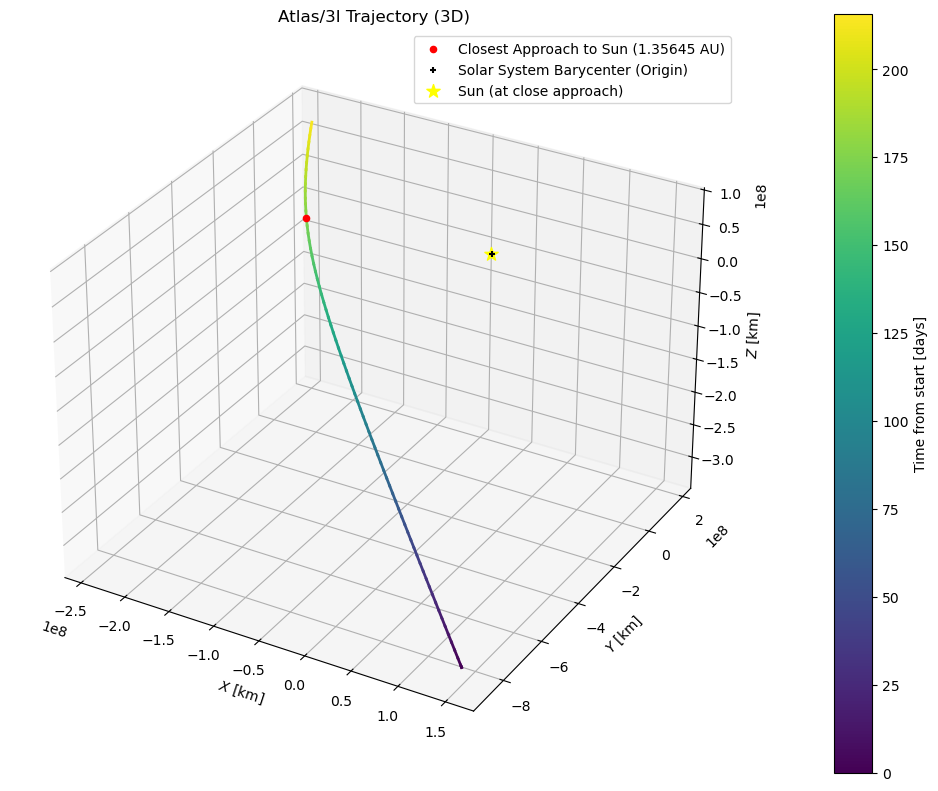

In [20]:
estimated_state_history = pod_output.simulation_results_per_iteration[
    -1
].dynamics_results.state_history

time2plt = np.array(list(estimated_state_history.keys()))
time2plt_normalized = (time2plt - time2plt[0]) / (3600*24)

# Spacecraft trajectory relative to SSB
trajectory = np.vstack(list(estimated_state_history.values()))
sc_positions_ssb = trajectory[:, :3]

# Get Sun ephemeris object
sun_ephemeris = bodies.get('Sun').ephemeris

# Get Sun's position relative to SSB at all time steps
# Use a list comprehension to get Sun's position (index [0:3]) at each time
sun_positions_ssb = np.array([sun_ephemeris.cartesian_state(t)[0:3] for t in time2plt.flatten()])

# Calculate the relative position vector (spacecraft relative to Sun)
relative_positions_sc_to_sun = sc_positions_ssb - sun_positions_ssb

# Calculate the norm (distance) at each time step
distances_to_sun = np.linalg.norm(relative_positions_sc_to_sun, axis=1)

# Find the minimum distance and its index
min_norm_index = np.argmin(distances_to_sun)

# Get the time, distance, and positions at the true close approach
closest_approach_time_epoch = time2plt[min_norm_index]
closest_approach_utc_date = DateTime.to_python_datetime(DateTime.from_epoch(closest_approach_time_epoch))
closest_approach_m = distances_to_sun[min_norm_index]

# Get the SC and Sun positions (relative to SSB) at the time of close approach
sc_pos_at_close_approach = sc_positions_ssb[min_norm_index, :]
sun_pos_at_close_approach = sun_positions_ssb[min_norm_index, :]

# --- Plotting ---
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111, projection='3d')

# Create a colormap based on time
cmap = plt.get_cmap('viridis')
colors = cmap(time2plt_normalized / time2plt_normalized.max())

# Plot the trajectory with color varying by time
for i in range(len(trajectory) - 1):
    ax1.plot(trajectory[i:i+2, 0]/1000, trajectory[i:i+2, 1]/1000, trajectory[i:i+2, 2]/1000, color=colors[i], linewidth=2)

# Convert closest approach distance to AU for the label
closest_approach_au = (closest_approach_m * u.m).to(u.au)

print(f"Closest Approach to Sun: {closest_approach_utc_date}")
print(f"Closest Approach Distance: {closest_approach_au} AU")

# Plot the spacecraft's position at closest approach
ax1.scatter(sc_pos_at_close_approach[0]/1000, sc_pos_at_close_approach[1]/1000, sc_pos_at_close_approach[2]/1000, # type: ignore
            color='red', marker='o', s=20, label=f'Closest Approach to Sun ({closest_approach_au.value:.5f} AU)')

# Plot the SSB (origin)
ax1.scatter(0, 0, 0, label='Solar System Barycenter (Origin)', color='black', marker='+')

# Plot the Sun's position at the time of closest approach
ax1.scatter(sun_pos_at_close_approach[0]/1000, sun_pos_at_close_approach[1]/1000, sun_pos_at_close_approach[2]/1000, 
            color='yellow', marker='*', s=100, label='Sun (at close approach)')
ax1.set_title("Atlas/3I Trajectory (3D)")
ax1.set_xlabel(r'$X$ [km]')
ax1.set_ylabel(r'$Y$ [km]')
ax1.set_zlabel(r'$Z$ [km]')
ax1.legend()

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array(time2plt_normalized)
cbar = fig.colorbar(sm, ax=ax1, pad=0.1)
cbar.set_label('Time from start [days]')
plt.tight_layout()
plt.show()

### Covariance Propagation

Finally, we propagate the covariance of our estimate along the trajectory, transforming it to the RSW (Radial-Satellite-Weight) frame to better understand the uncertainty in the orbital position.

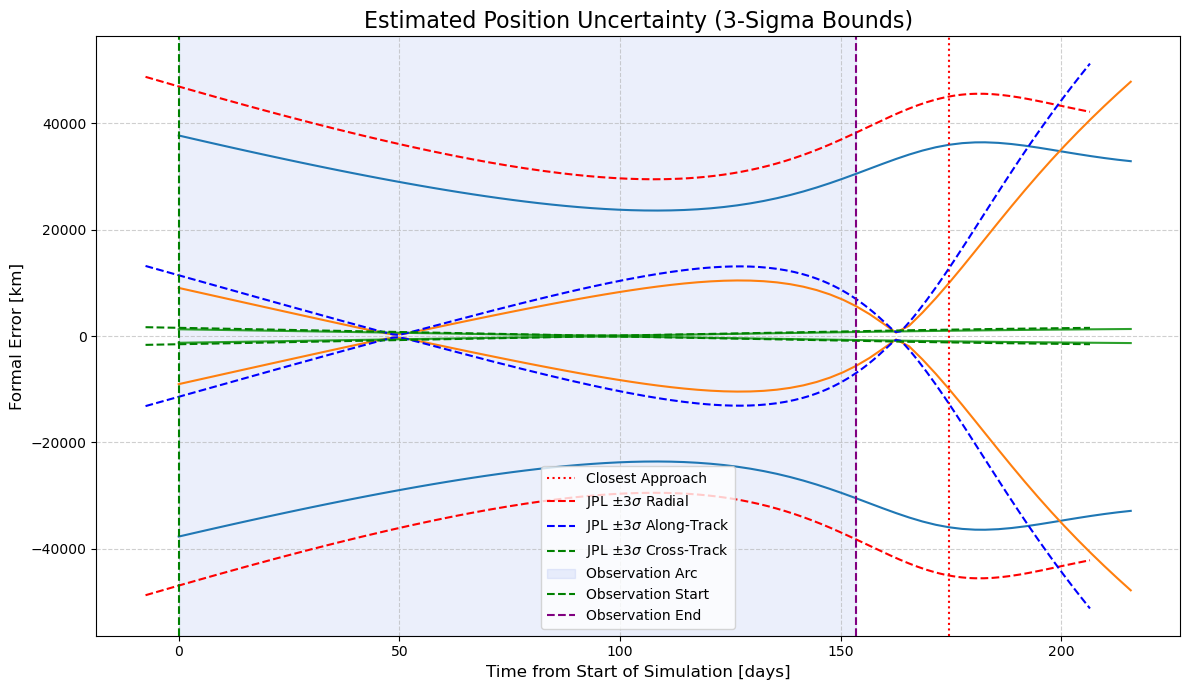

In [21]:
# Covariace propagation
_, covariance_history = estimation.estimation_analysis.propagate_covariance_split_output(
    pod_output.covariance,
    estimator.state_transition_interface,
    estimated_state_history.keys(),
)

inertial_to_rsw_state_rotation_matrices = []
for state in estimated_state_history.values():
    inertial_to_rsw_rm = np.zeros((6, 6))
    i2rsw = inertial_to_rsw_rotation_matrix(state)
    inertial_to_rsw_rm[:3, :3] = i2rsw
    inertial_to_rsw_rm[3:, 3:] = i2rsw
    inertial_to_rsw_state_rotation_matrices.append(inertial_to_rsw_rm)

covariance_history_rsw = [
    inertial_to_rsw_state_rotation_matrices[i]
    @ covariance_history[i]
    @ inertial_to_rsw_state_rotation_matrices[i].T
    for i in range(len(covariance_history))
]
formal_error_history_rsw = np.array(
    [np.sqrt(np.diag(cov)) for cov in covariance_history_rsw]
)

labels = ["R", "S", "W"]
times_plot = (
    estimated_state_history.keys()
)  # approximate for plot ticks

sigma_level = 3
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

# Convert time from seconds since J2000 to days from the start of the simulation
simulation_times = np.array(list(estimated_state_history.keys()))
times_plot_days = (simulation_times - simulation_times[0]) / 86400.0

labels = ["Radial (R)", "Along-Track (S)", "Cross-Track (W)"]
sigma_level = 3

for i in range(3):
    # Plot the positive 3-sigma bound
    ax.plot(
        times_plot_days,
        sigma_level * formal_error_history_rsw[:, i] / 1e3,  # Convert from m to km
        linestyle="-",
        color=cm.tab10(i),
        )
    # Plot the negative 3-sigma bound
    ax.plot(
        times_plot_days,
        -sigma_level * formal_error_history_rsw[:, i] / 1e3,  # Convert from m to km
        linestyle="-",
        color=cm.tab10(i),
        )

# Add a vertical line at the closest approach date
closest_approach_time_days = (DateTime.to_epoch(DateTime.from_python_datetime(closest_approach_utc_date)) - simulation_times[0]) / 86400.0
ax.axvline(x=closest_approach_time_days, color='red', linestyle=':', label='Closest Approach')

times_get_eph = np.linspace(epoch_start_nobuffer, epoch_end_nobuffer, 500)

times_get_eph = [DateTime.from_epoch(time).to_julian_day() for time in times_get_eph]

uncertainty_file_path = "data/3I-Ephemeris-Uncertainty.ecsv"
ephemeris_uncertainty_table = Table.read(uncertainty_file_path)
def add_uncertainty_table_to_cartesian_plot(
        axs,
        ephemeris_uncertainty_table: Table,
        simulation_start_time: float,  # Add simulation start time as an argument
        in_RSW: bool = False
):
    """
    Adds JPL ephemeris uncertainty data to an existing plot.
    The time axis is made relative to the provided simulation_start_time.
    """
    if not in_RSW:
        # This part remains for inertial frame plotting if needed
        uncertainty_history = np.array(
            [
                ephemeris_uncertainty_table["ephemeris_time"],
                ephemeris_uncertainty_table["x_s"],
                ephemeris_uncertainty_table["y_s"],
                ephemeris_uncertainty_table["z_s"],
            ]
        ).T
    else:
        # Using RSW data
        uncertainty_history = np.array(
            [
                ephemeris_uncertainty_table["datetime_jd"],
                ephemeris_uncertainty_table["r_s_1"]*3,
                ephemeris_uncertainty_table["t_s"]*3,
                ephemeris_uncertainty_table["n_s_1"]*3,
            ]
        ).T

    # Convert JPL Julian Day times to TDB seconds since J2000
    jpl_jd_times = uncertainty_history[:, 0]
    jpl_tdb_seconds = [time_representation.julian_day_to_seconds_since_epoch(jd) for jd in jpl_jd_times]

    # Calculate the time axis relative to the simulation start, in days
    jpl_relative_days = (np.array(jpl_tdb_seconds) - simulation_start_time) / 86400.0

    # --- MODIFICATION START ---
    # Get the uncertainty values (in AU) and convert them to km
    jpl_uncertainties_au = uncertainty_history[:, 1:4]
    # tudatpy.constants.ASTRONOMICAL_UNIT is in meters, so divide by 1000 for km
    jpl_uncertainties_km = jpl_uncertainties_au * (constants.ASTRONOMICAL_UNIT / 1000.0)
    # --- MODIFICATION END ---

    # Plot the JPL uncertainty bands
    axs.plot(
        jpl_relative_days,
        np.array([jpl_uncertainties_km[:, 0], -jpl_uncertainties_km[:, 0]]).T,
        linestyle="--",
        color="red",
        label="JPL $\pm 3\sigma$ Radial",
    )
    axs.plot(
        jpl_relative_days,
        np.array([jpl_uncertainties_km[:, 1], -jpl_uncertainties_km[:, 1]]).T,
        linestyle="--",
        color="blue",
        label="JPL $\pm 3\sigma$ Along-Track",
    )
    axs.plot(
        jpl_relative_days,
        np.array([jpl_uncertainties_km[:, 2], -jpl_uncertainties_km[:, 2]]).T,
        linestyle="--",
        color="green",
        label="JPL $\pm 3\sigma$ Cross-Track",
    )

add_uncertainty_table_to_cartesian_plot(
    ax,
    ephemeris_uncertainty_table=ephemeris_uncertainty_table,
    simulation_start_time=simulation_times[0],  # Pass the simulation start time
    in_RSW=True
)

# Add vertical lines for the start and end dates of observations
observation_start_time_days = (epoch_start_nobuffer - simulation_times[0]) / 86400.0
observation_end_time_days = (epoch_end_nobuffer  - simulation_times[0])/ 86400.0
# Add shaded region for observation arc
ax.axvspan(observation_start_time_days, observation_end_time_days,
           alpha=0.1, color='royalblue', label='Observation Arc')
ax.axvline(x=observation_start_time_days, color='green', linestyle='--', label='Observation Start')
ax.axvline(x=observation_end_time_days, color='purple', linestyle='--', label='Observation End')
ax.set_title(f"Estimated Position Uncertainty ({sigma_level}-Sigma Bounds)", fontsize=16)
ax.set_xlabel("Time from Start of Simulation [days]", fontsize=12)
ax.set_ylabel("Formal Error [km]", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=10)

plt.tight_layout()
plt.show()

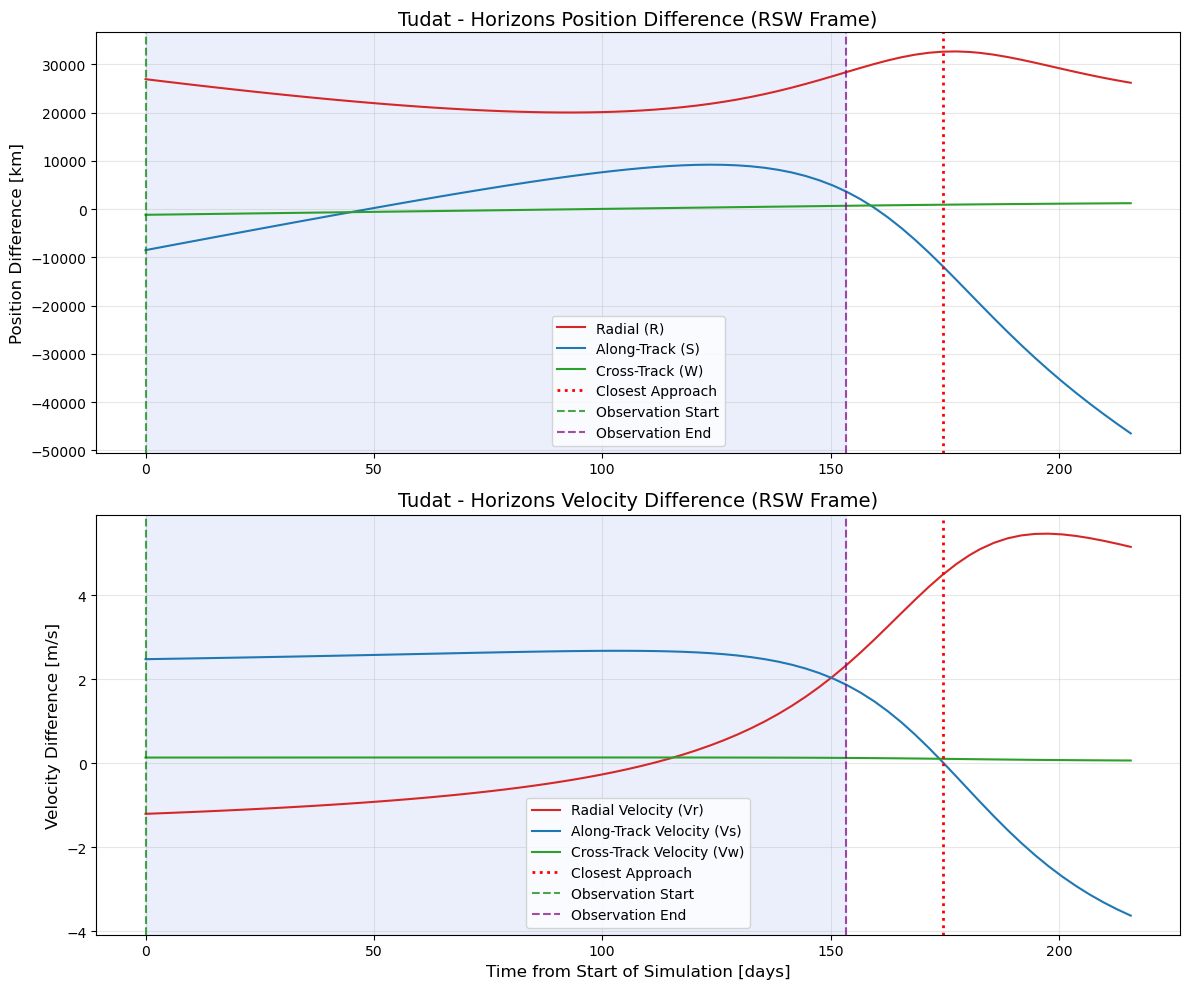

In [22]:
# Compute difference between Horizons and Tudat orbits in RSW frame

# First, we need to get Horizons ephemeris at the same times as our trajectory
trajectory_times = np.array(list(estimated_state_history.keys()))

# Query Horizons for the full trajectory time span
horizons_query_full = HorizonsQuery(
    query_id=f"{mpc_codes[0]};",
    location=f"@0",  # SSB
    epoch_list=trajectory_times.tolist(),
    extended_query=True,
)

horizons_ephemeris_full = horizons_query_full.cartesian(
    frame_orientation=global_frame_orientation
)

# Extract Horizons states (skip first column which is time)
horizons_states = horizons_ephemeris_full[:, 1:]

# Compute the difference in inertial frame
state_diff_inertial = trajectory - horizons_states

# Transform the difference to RSW frame for each time step
state_diff_rsw = np.zeros_like(state_diff_inertial)

for i, (state_tudat, state_horizons) in enumerate(zip(trajectory, horizons_states)):
    # Compute RSW rotation matrix using Tudat state (or could use Horizons, should be similar)
    inertial_to_rsw_rm = np.zeros((6, 6))
    i2rsw = inertial_to_rsw_rotation_matrix(state_tudat)
    inertial_to_rsw_rm[:3, :3] = i2rsw
    inertial_to_rsw_rm[3:, 3:] = i2rsw

    # Transform the state difference to RSW frame
    state_diff_rsw[i] = inertial_to_rsw_rm @ state_diff_inertial[i]

# Extract position and velocity differences in RSW
position_diff_rsw = state_diff_rsw[:, :3]  # R, S, W components [m]
velocity_diff_rsw = state_diff_rsw[:, 3:]  # Vr, Vs, Vw components [m/s]

# Convert times to days from start for plotting
times_plot_days = (trajectory_times - trajectory_times[0]) / 86400.0

# Plot the position differences in RSW frame
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Position differences
ax1.plot(times_plot_days, position_diff_rsw[:, 0] / 1e3, label='Radial (R)', color='tab:red')
ax1.plot(times_plot_days, position_diff_rsw[:, 1] / 1e3, label='Along-Track (S)', color='tab:blue')
ax1.plot(times_plot_days, position_diff_rsw[:, 2] / 1e3, label='Cross-Track (W)', color='tab:green')

# Add vertical line at closest approach
closest_approach_time_days = (DateTime.to_epoch(DateTime.from_python_datetime(closest_approach_utc_date)) - trajectory_times[0]) / 86400.0
ax1.axvline(x=closest_approach_time_days, color='red', linestyle=':', linewidth=2, label='Closest Approach')

# Add vertical lines for observation start/end
observation_start_time_days = (epoch_start_nobuffer - trajectory_times[0]) / 86400.0
observation_end_time_days = (epoch_end_nobuffer - trajectory_times[0]) / 86400.0
ax1.axvline(x=observation_start_time_days, color='green', linestyle='--', alpha=0.7, label='Observation Start')
ax1.axvline(x=observation_end_time_days, color='purple', linestyle='--', alpha=0.7, label='Observation End')

ax1.set_ylabel('Position Difference [km]', fontsize=12)
ax1.set_title('Tudat - Horizons Position Difference (RSW Frame)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

# Velocity differences
ax2.plot(times_plot_days, velocity_diff_rsw[:, 0], label='Radial Velocity (Vr)', color='tab:red')
ax2.plot(times_plot_days, velocity_diff_rsw[:, 1], label='Along-Track Velocity (Vs)', color='tab:blue')
ax2.plot(times_plot_days, velocity_diff_rsw[:, 2], label='Cross-Track Velocity (Vw)', color='tab:green')

ax2.axvline(x=closest_approach_time_days, color='red', linestyle=':', linewidth=2, label='Closest Approach')
ax2.axvline(x=observation_start_time_days, color='green', linestyle='--', alpha=0.7, label='Observation Start')
ax2.axvline(x=observation_end_time_days, color='purple', linestyle='--', alpha=0.7, label='Observation End')

ax2.set_xlabel('Time from Start of Simulation [days]', fontsize=12)
ax2.set_ylabel('Velocity Difference [m/s]', fontsize=12)
ax2.set_title('Tudat - Horizons Velocity Difference (RSW Frame)', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)
# Add shaded region for observation arc
ax2.axvspan(observation_start_time_days, observation_end_time_days,
           alpha=0.1, color='royalblue', label='Observation Arc')
ax1.axvspan(observation_start_time_days, observation_end_time_days,
           alpha=0.1, color='royalblue', label='Observation Arc')
plt.tight_layout()
plt.show()

In [23]:
# Print summary statistics
print("\n" + "="*60)
print("SUMMARY: Tudat vs Horizons Differences (RSW Frame)")
print("="*60)
print("\nPosition Differences:")
print(f"  Radial (R):      max = {np.max(np.abs(position_diff_rsw[:, 0]))/1e3:.3f} km, "
      f"mean = {np.mean(np.abs(position_diff_rsw[:, 0]))/1e3:.3f} km")
print(f"  Along-Track (S): max = {np.max(np.abs(position_diff_rsw[:, 1]))/1e3:.3f} km, "
      f"mean = {np.mean(np.abs(position_diff_rsw[:, 1]))/1e3:.3f} km")
print(f"  Cross-Track (W): max = {np.max(np.abs(position_diff_rsw[:, 2]))/1e3:.3f} km, "
      f"mean = {np.mean(np.abs(position_diff_rsw[:, 2]))/1e3:.3f} km")

print("\nVelocity Differences:")
print(f"  Radial (Vr):      max = {np.max(np.abs(velocity_diff_rsw[:, 0])):.6f} m/s, "
      f"mean = {np.mean(np.abs(velocity_diff_rsw[:, 0])):.6f} m/s")
print(f"  Along-Track (Vs): max = {np.max(np.abs(velocity_diff_rsw[:, 1])):.6f} m/s, "
      f"mean = {np.mean(np.abs(velocity_diff_rsw[:, 1])):.6f} m/s")
print(f"  Cross-Track (Vw): max = {np.max(np.abs(velocity_diff_rsw[:, 2])):.6f} m/s, "
      f"mean = {np.mean(np.abs(velocity_diff_rsw[:, 2])):.6f} m/s")

# 3D position difference magnitude
position_diff_magnitude = np.linalg.norm(position_diff_rsw, axis=1)
print(f"\n3D Position Difference Magnitude:")
print(f"  max = {np.max(position_diff_magnitude)/1e3:.3f} km, "
      f"mean = {np.mean(position_diff_magnitude)/1e3:.3f} km")
print("="*60)


SUMMARY: Tudat vs Horizons Differences (RSW Frame)

Position Differences:
  Radial (R):      max = 32692.636 km, mean = 24986.520 km
  Along-Track (S): max = 46506.765 km, mean = 10344.047 km
  Cross-Track (W): max = 1223.423 km, mean = 669.589 km

Velocity Differences:
  Radial (Vr):      max = 5.472186 m/s, mean = 1.925339 m/s
  Along-Track (Vs): max = 3.623215 m/s, mean = 2.325859 m/s
  Cross-Track (Vw): max = 0.142368 m/s, mean = 0.129001 m/s

3D Position Difference Magnitude:
  max = 53391.098 km, mean = 28306.964 km


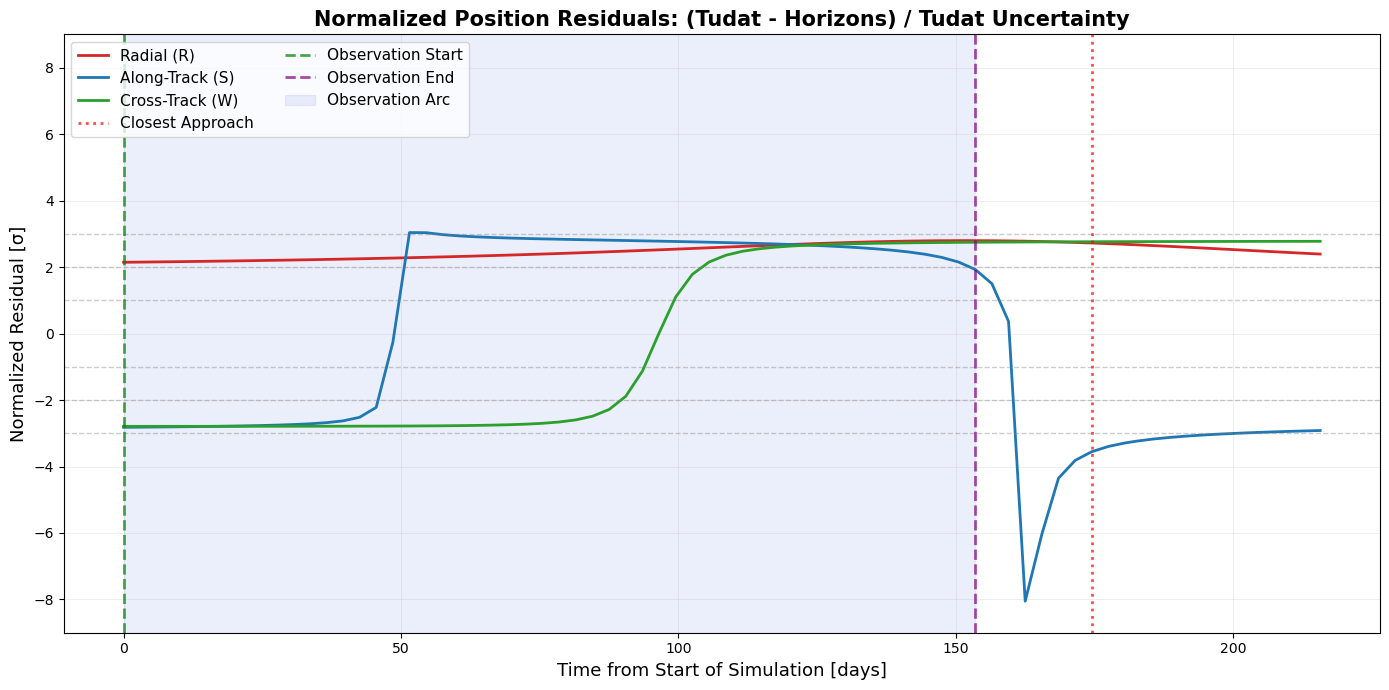

In [24]:
# Compute normalized residuals: (Tudat - Horizons) / Uncertainty
# This shows how many sigmas the difference is from zero

# We already have:
# - position_diff_rsw: differences in RSW frame [m]
# - formal_error_history_rsw: 1-sigma uncertainties in RSW frame [m]
# - trajectory_times: time vector

# Compute normalized residuals (in units of sigma)
normalized_residuals_rsw = np.zeros_like(position_diff_rsw)

for i in range(len(position_diff_rsw)):
    # Divide difference by 1-sigma uncertainty
    # formal_error_history_rsw contains 1-sigma values
    normalized_residuals_rsw[i] = position_diff_rsw[i] / formal_error_history_rsw[i, :3]

# Convert times to days from start for plotting
times_plot_days = (trajectory_times - trajectory_times[0]) / 86400.0

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

# Plot normalized residuals
ax.plot(times_plot_days, normalized_residuals_rsw[:, 0],
        label='Radial (R)', color='tab:red', linewidth=2)
ax.plot(times_plot_days, normalized_residuals_rsw[:, 1],
        label='Along-Track (S)', color='tab:blue', linewidth=2)
ax.plot(times_plot_days, normalized_residuals_rsw[:, 2],
        label='Cross-Track (W)', color='tab:green', linewidth=2)

# Add horizontal reference lines at ±1σ, ±2σ, ±3σ
for sigma_level in [1, 2, 3]:
    ax.axhline(y=sigma_level, color='gray', linestyle='--',
               alpha=0.4, linewidth=1)
    ax.axhline(y=-sigma_level, color='gray', linestyle='--',
               alpha=0.4, linewidth=1)

# Add vertical lines for key events
closest_approach_time_days = (DateTime.to_epoch(
    DateTime.from_python_datetime(closest_approach_utc_date)) - trajectory_times[0]) / 86400.0
observation_start_time_days = (epoch_start_nobuffer - trajectory_times[0]) / 86400.0
observation_end_time_days = (epoch_end_nobuffer - trajectory_times[0]) / 86400.0

ax.axvline(x=closest_approach_time_days, color='red', linestyle=':',
           linewidth=2, label='Closest Approach', alpha=0.7)
ax.axvline(x=observation_start_time_days, color='green', linestyle='--',
           alpha=0.7, linewidth=2, label='Observation Start')
ax.axvline(x=observation_end_time_days, color='purple', linestyle='--',
           alpha=0.7, linewidth=2, label='Observation End')

# Add shaded region for observation arc
ax.axvspan(observation_start_time_days, observation_end_time_days,
           alpha=0.1, color='royalblue', label='Observation Arc')

# Formatting
ax.set_xlabel('Time from Start of Simulation [days]', fontsize=13)
ax.set_ylabel('Normalized Residual [σ]', fontsize=13)
ax.set_title('Normalized Position Residuals: (Tudat - Horizons) / Tudat Uncertainty',
             fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.legend(fontsize=11, loc='upper left', ncol=2)

# Set y-axis limits to focus on ±4σ range (adjust if needed)
ax.set_ylim(-9, 9)

plt.tight_layout()
plt.show()

In [25]:
# Print detailed statistics
print("\n" + "="*70)
print("NORMALIZED RESIDUALS STATISTICS (in units of σ)")
print("="*70)

# Statistics during observation arc
obs_mask = (trajectory_times >= epoch_start_nobuffer) & (trajectory_times <= epoch_end_nobuffer)

print("\nDuring Observation Arc (Day 0 to ~150):")
print("-" * 70)
for i, comp in enumerate(['Radial (R)', 'Along-Track (S)', 'Cross-Track (W)']):
    obs_data = normalized_residuals_rsw[obs_mask, i]
    print(f"\n{comp}:")
    print(f"  Mean:   {np.mean(obs_data):+.3f}σ")
    print(f"  Std:    {np.std(obs_data):.3f}σ")
    print(f"  Max:    {np.max(obs_data):+.3f}σ")
    print(f"  Min:    {np.min(obs_data):+.3f}σ")
    print(f"  |Max|:  {np.max(np.abs(obs_data)):.3f}σ")

    # Count exceedances
    exceed_1s = np.sum(np.abs(obs_data) > 1)
    exceed_2s = np.sum(np.abs(obs_data) > 2)
    exceed_3s = np.sum(np.abs(obs_data) > 3)
    total = len(obs_data)

    print(f"  Points exceeding ±1σ: {exceed_1s}/{total} ({100*exceed_1s/total:.1f}%)")
    print(f"  Points exceeding ±2σ: {exceed_2s}/{total} ({100*exceed_2s/total:.1f}%)")
    print(f"  Points exceeding ±3σ: {exceed_3s}/{total} ({100*exceed_3s/total:.1f}%)")

# Statistics for full trajectory
print("\n\nFull Trajectory (Day 0 to ~230):")
print("-" * 70)
for i, comp in enumerate(['Radial (R)', 'Along-Track (S)', 'Cross-Track (W)']):
    full_data = normalized_residuals_rsw[:, i]
    print(f"\n{comp}:")
    print(f"  Mean:   {np.mean(full_data):+.3f}σ")
    print(f"  Std:    {np.std(full_data):.3f}σ")
    print(f"  Max:    {np.max(full_data):+.3f}σ")
    print(f"  Min:    {np.min(full_data):+.3f}σ")
    print(f"  |Max|:  {np.max(np.abs(full_data)):.3f}σ")


NORMALIZED RESIDUALS STATISTICS (in units of σ)

During Observation Arc (Day 0 to ~150):
----------------------------------------------------------------------

Radial (R):
  Mean:   +2.417σ
  Std:    0.221σ
  Max:    +2.795σ
  Min:    +2.143σ
  |Max|:  2.795σ
  Points exceeding ±1σ: 54/54 (100.0%)
  Points exceeding ±2σ: 54/54 (100.0%)
  Points exceeding ±3σ: 0/54 (0.0%)

Along-Track (S):
  Mean:   +0.749σ
  Std:    2.602σ
  Max:    +3.038σ
  Min:    -2.821σ
  |Max|:  3.038σ
  Points exceeding ±1σ: 53/54 (98.1%)
  Points exceeding ±2σ: 53/54 (98.1%)
  Points exceeding ±3σ: 2/54 (3.7%)

Cross-Track (W):
  Mean:   -0.905σ
  Std:    2.450σ
  Max:    +2.742σ
  Min:    -2.792σ
  |Max|:  2.792σ
  Points exceeding ±1σ: 53/54 (98.1%)
  Points exceeding ±2σ: 49/54 (90.7%)
  Points exceeding ±3σ: 0/54 (0.0%)


Full Trajectory (Day 0 to ~230):
----------------------------------------------------------------------

Radial (R):
  Mean:   +2.479σ
  Std:    0.222σ
  Max:    +2.795σ
  Min:    +2.143